# Sms2fr

Translate text message abbreviations to actual french.

This program is based on _Rewriting the orthography of SMS messages_, François Yvon, In Natural Language Engineering, volume 16, 2010.  It uses two specific automata created using a machine learning method.

- The first one is used to add the different syllable with a similar sound as those from the text (graphemic model).
- The second one treats the probabilities of those changes considering the syntax of the text (syntactic model).

Notes:
- The following example does not rely on actual weights and labels from the algorithm and these values were chosen as theoritical values.
- The characters '#', '[' and ']' are considered special characters by the trained automata and not accepted in the original text.

References:
- [yvon.2010.nle](References.ipynb#yvon.2010.nle)

### The method

In [1]:
import vcsn
ctx = vcsn.context('lal, nmin')

Considering we enter 'bo' in the `sms2fr` algorithm, the following automaton is created:

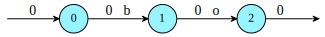

In [2]:
ctx.expression('bo').automaton()

It is then composed with the graphemic model (weights will depend on frequency of usage in the language):

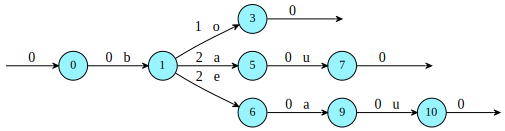

In [3]:
ctx.expression('b(<1>o+<2>au+<2>eau)').standard()

And it is finally composed with the syntactic model (weights will depend on probability of presence of this grapheme after the letter b):

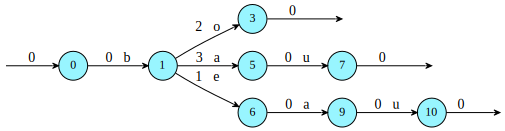

In [4]:
res = ctx.expression('b(<2>o+<3>au+<1>eau)').standard()
res

The algorithm will then choose the path with the lightest weight (in the tropical weightset Rmin), here: 'beau'.

In [5]:
res.lightest()

<1>beau

### Initialization
Unfortunately, for lack of a binary format for automata, loading these automata takes about ten seconds.

In [6]:
import re

graphs_dir = vcsn.config('configuration.datadir') + '/sms2fr/'
# Read the graphemic automaton.
grap = vcsn.automaton(filename=graphs_dir + 'graphemic.efsm')
# Read the syntactic automaton.
synt = vcsn.automaton(filename=graphs_dir + 'syntactic.efsm').partial_identity()

### Core algorithm

In [7]:
def sms2fr(sms, k=1):
    # Graphemic automaton expects input of the format '[#this#is#my#text#]'.
    sms = re.escape('[#' + sms.replace(' ', '#') + '#]')
    ctx = vcsn.context('lal, rmin')
    # Translate the sms into an automaton.
    sms_aut = ctx.expression(sms).automaton().partial_identity().proper()
    # First composition with graphemic automaton.
    aut_g = sms_aut.compose(grap).coaccessible().strip()
    # Second composition with syntactic automaton.
    aut_s = aut_g.compose(synt).coaccessible().strip().project(1).proper()
    # Retrieve the most likely path to correspond to french translation.
    return aut_s.lightest(k)

### Examples

In [8]:
sms2fr('slt')

<24.5659>\[#salut#\]

In [9]:
sms2fr('bjr')

<30.8694>\[#bonjour#\]

In [10]:
sms2fr('on svoit 2m1 ?')

<190.602>\[#on#se#voit#demain#?#\]

In [11]:
sms2fr('t pa mal1 100 ton mento')

<201.495>\[#t\'#es#pas#malin#sans#ton#manteau#\]

It is also possible to get multiple traduction proposition by using Vcsn's implementations of K shortest path algorithms.

In [12]:
sms2fr('bjr mond', 3)

<96.7537>\[#bonjour#mont#\] + <65.9137>\[#bonjour#monde#\] + <97.0141>\[#bonjour#mondes#\]

In [13]:
sms2fr('tante', 3)

<69.6353>\[#tant#\] + <56.3297>\[#tante#\] + <63.2217>\[#tantes#\]